# Inverse Problems : The Bayesian Approach with Plug and Play (PnP) priors

This numerical tour follows a Bayesian approach with Plug and Play (PnP) priors for solving inverse problems. These data-driven approach make use of learned implicit representation of the prior density while keeping an explicit likelihood density. Our aim is to perform image deconvolution and uncertainty quantification using [Langevin algorithms](https://epubs.siam.org/doi/abs/10.1137/21M1406349?journalCode=sjisbi) for sampling under PnP priors.

In [1]:
import math
import torch
import numpy as np
import time as time
from tqdm.auto import tqdm
from PIL import Image

from sampling_tools import *

# Check if there's a GPU available and run on GPU, otherwise run on CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

C:\Users\pdobson\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Introduction

For many problems in imaging, we are interested in recovering an image  $x \in \mathbb{R}^d$, from a set of measurements $y \in \mathbb{R}^d$. We consider measurement models of the form 

$$y = Ax + w,$$ 

where $A \in \mathbb{R}^{d \times d}$ is a linear operator and $w \sim N(0, \sigma^2 I_d)$ is a noise term.  Here, we study the case where both $A$ and $\sigma>0$ are known.  The recovery of $x$ from $y$ is often ill posed or ill conditioned, so we regularize with prior knowledge.

The measurement model defines a likelihood function $p(y|x)\propto e^{-f_{y}(x)}$, where $f_{y}$ (negative log-likelihood) is convex and continuously differentiable with $L_{y}$-Lipschitz gradient. The prior knowledge about $x$ is encoded by a prior distribution $p(x)$. Then, from the Bayes Theorem, the posterior distribution $p(x|y)$ is defined as

$$p(x|y) = \dfrac{p(y|x)p(x)}{\int_{\mathbb{R}^d}p(y|\tilde{x})p(\tilde{x})d\tilde{x}} ~~~,$$

which underpins all inference about $x$ given the observation $y$. 

Many works in the Bayesian imaging literature consider relatively simple handcrafted priors promoting sparsity in transformed domains or piecewise regularity (e.g., involving the $\ell_1$ norm or the total variation pseudonorm). Special  attention  is  given  in  the  literature  to  models that are log-concave, as this enables the use of Bayesian computation  algorithms  that  scale  efficiently  to  high  dimensions  and  which  have  detailed convergence guarantees. For a relevant implementation of such models check the notebooks for [MYULA](https://github.com/MI2G/sampling-tutorials) and [SKROCK](https://github.com/MI2G/sampling-tutorials).

Our aim here is to calculate the Minimum Mean Square Error (MMSE) Bayesian estimator defined as

$$\hat{x}_{MMSE} = \operatorname{argmin}_{u\in\mathbb{R}^{d}}\mathbb{E}\left[||x-u||^{2}|y\right]= \mathbb{E}(x|y) = \int_{\mathbb{R}^{d}}\tilde{x}p(\tilde{x}|y)d\tilde{x}.$$

Moreover, as an illustration of an uncertainty visualisation analysis, we also calculate the posterior variance for each image pixel $x_{i}$, for $i = 1,\ldots,d$, defined as

$$Var(x_i|y) = \mathbb{E}(x_i^{2}|y) - (\mathbb{E}(x_i|y))^{2},$$

where

$$\mathbb{E}(x_i^{2}|y)=\int_{\mathbb{R}^{d}}\tilde{x_i}^{2}p(\tilde{x_i}|y)d\tilde{x_i}.$$

## Loading and Blurring the Image
Deconvolution corresponds to removing a blur from an image. First we load the image to be used for the rest of the notebook.

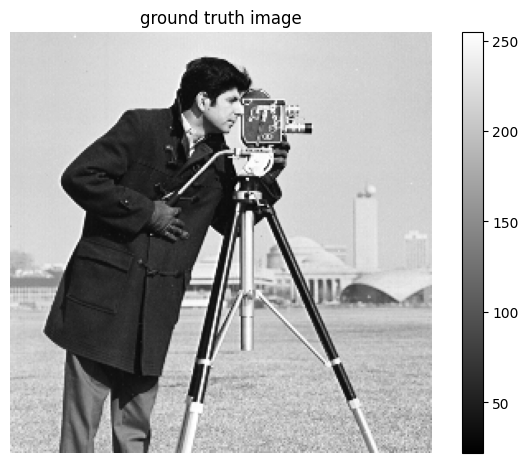

In [2]:
# Load grayscale image
im = np.array(Image.open("cman.png")) 
plot_im(im, "ground truth image")

# Convert to torch tensor
x = torch.Tensor(im/255.).to(device)

Define the convolution kernel $A$. Here a $5\times 5$ uniform blur is used. The `blur_operators()` function returns the functions handles $A$ and $A^T$ that implement the forward operations $Ax$ and $A^Tx$ respectively (computed by calling $A(x)$ and $AT(x)$) as well as the spectral norm $||AA^T||_{2}^{2}$.

The calculation of $||AA^T||_{2}^{2}$ is necessary since it appears in the Lipschitz constant of the model and plays a role for the stepsize of the presented algorithms.

In [3]:
kernel_len = [5,5]
size = [im.shape[0],im.shape[1]]
type_blur = "uniform"
A, AT, AAT_norm = blur_operators(kernel_len, size, type_blur, device)

Apply the filter and add some noise to obtain the measurements $y = Ax + w$ and achieve a blurred signal-to-noise ratio (BSNR) of $40$ dB.

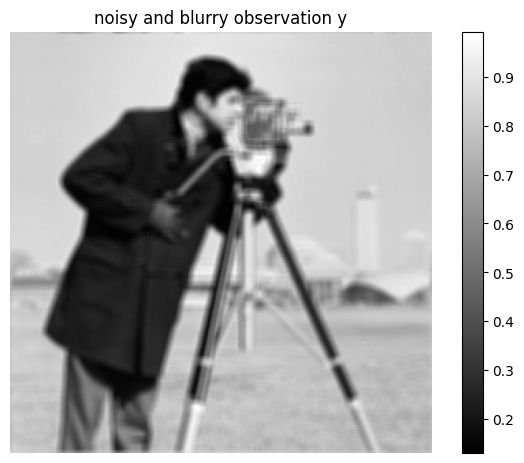

In [4]:
y0 = A(x)

BSNRdb = 40
sigma = torch.linalg.matrix_norm(A(x)-torch.mean(A(x)), ord='fro')/math.sqrt(torch.numel(x)*10**(BSNRdb/10))

y = y0 + sigma * torch.randn_like(x)
plot_im(y, "noisy and blurry observation y")

# Markov Chain Monte Carlo (MCMC) methods in imaging inverse problems

It is clear that the calculation of the integrals defined above is a computationally infeasible task in high dimensions. Stochastic simulation algorithms, namely Markov Chain Monte Carlo (MCMC) algorithms, estimate these integrals by sampling. For example, if we could get i.i.d samples $\{X_{i}\}_{i=1}^{N}$ from $p(x|y;\theta)$ the posterior mean is approximated by

$$\hat{x}_{MMSE}\approx\dfrac{1}{N}\sum_{i=1}^{N}X_{i},$$

with the Monte Carlo approximation error vanishing as $N → ∞$.

The question that arises here is how can we sample from the posterior. Under a smooth log-concave prior, a common approach is to solve the overdamped Langevin stochastic differential equation (SDE)

$$dX_{t} = \nabla \log p(X_{t}|y;\theta) dt + \sqrt{2}dW_{t} = \nabla \log p(y|X_{t}) dt+ \nabla \log p(X_{t}) dt+ \sqrt{2}dW_{t} ~~,$$

where $(W_{t})_{t\geq0}$ is a $d$-dimensional Brownian motion. Under mild conditions, the above SDE has a unique strong solution $(X_{t})_{t>0}$ that admits the posterior of interest $p(x|y;\theta)$ as its  unique stationary density.

In general, one cannot solve the overdamped Langevin SDE analytically and needs to resort to the use of numerical methods. The simplest numerical method one can employ is the Euler-Maruyama method, which gives rise to the unadjusted Langevin algorithm (ULA), which defines a Markov Chain $\{ X_{k},  k \in \mathbb{N}\}$ using the following one step recursion 


$$X_{k+1} = X_{k} + \delta\nabla \log p(y|X_{k}) + \delta\nabla \log p(X_{k})+ \sqrt{2\delta}Z_{k+1} ~~,$$

where $\{Z_{k} : k\in \mathbb{N}\}$ is a family of i.i.d $d$-dimensional Gaussian random variables with zero mean and identity covariance matrix and $\delta$ is the time-step. When the prior $p(x)$ is log-concave but not smooth, one can approximate the gradient of $U(x) = -\log p(x)$ by the gradient of the Moreau Yosida (MY) envelope of $U_\lambda(x)$ given by $\nabla U_\lambda(x) = \frac{1}{\lambda}(x-\mathrm{prox}_U^\lambda(x))$. Then, the Moreau Yosida ULA (MYULA) can be used as

$$X_{k+1} = X_{k} + \delta\nabla \log p(y|X_{k}) + \frac{\delta}{\lambda}(\mathrm{prox}_U^\lambda(X_{k})-X_{k})+ \sqrt{2\delta}Z_{k+1} ~~.$$

For implementation of MY samplers under log-concave priors check the notebooks here and here.


## Likelihood

Since, we assumed Gaussian noise, the likelihood $p(y|x)$ is Gaussian given from the forward model $y = Ax + w$. Here we keep track of the negative log-likelihood $$-\log p(y|x) = f_y(x) =\dfrac{1}{2\sigma^2}||y-Ax||^{2}_{2}.$$

In [5]:
f = lambda x,A : (torch.linalg.matrix_norm(y-A(x), ord='fro')**2.0)/(2.0*sigma**2)

Define the gradient of the negative log-likelihood $f_{y}$.
$$\nabla f_y(x) = A^T(Ax - y).$$

In [6]:
gradf = lambda x,A,AT : AT(A(x)-y)/sigma**2

The Lipschitz constant $L_{y}$ related to the specific likelihood's gradient (useful for the stepsize choice) is $\dfrac{||AA^T||_2}{\sigma^2}$. We calculated $||AA^T||_2$ earlier.

In [7]:
L_y = AAT_norm/(sigma**2)

## Introduce a Plug and Play prior

We are now ready to outline the way PnP priors can be used for Bayesian computation. For more details look the work of [Remi and al.](https://epubs.siam.org/doi/abs/10.1137/21M1406349?journalCode=sjisbi). Suppose the existence of an optimal and intractable prior distribution over $x$, namely $p^*(x)$, and an optimal posterior distribution over $x|y$, namely $p^*(x|y)$. The posterior distribution associated with the optimal $p^*(x)$ is given as 

$$p^*(x|y) = \dfrac{p(y|x)p^*(x)}{\int_{\mathbb{R}^d}p(y|\tilde{x})p^*(\tilde{x})d\tilde{x}} ~~~,$$

Since $p^*$ and its respective Lebesque measure are unknown, it is not straightforward to verify that $p^*(x|y)$ is proper and differentiable or that $\nabla \log p^*(x|y)$ is Lipschitz continuous - an important feature for convergent gradient-based algorithms. Thus, we approximate $p^*$ by a smooth density $p_\epsilon^*=G_\epsilon p^*$ where $G_\epsilon$ is a Gaussian smoothing kernel of bandwidth $\epsilon>0$. Then, by definition

$$p_\epsilon^*(x) = (2\pi\epsilon)^{-d/2} \int_{\mathbb{R}^d} \exp\left[-\frac{||x-\tilde{x}||_2^2}{2\epsilon}\right]p^*(\tilde{x})d\tilde{x} ~~~,$$

$$p_\epsilon^*(x|y) = \dfrac{p(y|x)p_\epsilon^*(x)}{\int_{\mathbb{R}^d}p(y|\tilde{x})p_\epsilon^*(\tilde{x})d\tilde{x}} ~~~.$$


The core idea of Bayesian computation with PnP priors is to perform approximate inference w.r.t. $p_\epsilon^*(x|y)$ and consequently make use of the $\nabla \log p_\epsilon^*(x|y)$. Specifically, we introduce the oracle MMSE denoiser $D^{*}_{\epsilon}$ defined as 

$$D^{*}_{\epsilon}(x) = (2\pi\epsilon)^{-d/2} \int_\mathbb{R}  \tilde{x}\exp\left[-\frac{||x-\tilde{x}||_2^2}{2\epsilon}\right]p^*(\tilde{x})d\tilde{x} ~~~.$$

It can be seen that $D^{*}_{\epsilon}$ is the MMSE estimator to recover an image $x \sim p^*(x)$ from a noisy observation $x_\epsilon\sim \mathcal{N}(x, \epsilon I)$. To associate $D^{*}_{\epsilon}$ with the gradient $x \rightarrow \nabla \log p_\epsilon^*(x)$, we make use of the Tweedie's identity which states that

$$\nabla \log p_\epsilon^*(x) = \frac{1}{\epsilon}(D^{*}_{\epsilon}(x) - x) ~~~.$$

Then, we can  express  a  ULA  recursion  for  sampling approximately from $p^*_\epsilon(x|y)$ as

$$X_{k+1} = X_{k} + \delta\nabla \log p^*_\epsilon(X_{k}|y ) + \sqrt{2\delta}Z_{k+1}  = X_{k} + \delta\nabla \log p(y|X_{k}) + \frac{\delta}{\epsilon}(D_\epsilon^*(X_{k})-X_{k}) + \sqrt{2\delta}Z_{k+1} ~~.$$

Since $D_\epsilon^*(\cdot)$ is intractable, we use the above equation as a starting point and we replace $D_\epsilon^*(\cdot)$ by a surrogate denoiser $D_\epsilon(\cdot)$ to approximate $ p_\epsilon^*(x|y)$ by the posterior density $p_\epsilon(x|y)$ related to $D_\epsilon(\cdot)$.

 ### Load the denoiser

Below, we load the denoiser $D_\epsilon(\cdot)$ which is a pretrained residual network presented in [Ryu and al.](https://proceedings.mlr.press/v97/ryu19a) with controlled Lipschitz constant $L = 1$. The Lipschitz continuity of the denoiser is important since this guarantees that $\nabla \log p_\epsilon(x|y)$ is also Lipschitz. Since the network is residual, $D_\epsilon(\cdot) = x - D'_\epsilon(\cdot)$, where $D'_\epsilon(\cdot)$ is the loaded network, denoted as `denoise()` and `model()` respectively. Finally, we assume that the denoiser $D'_\epsilon(\cdot)$ is pretrained at noise level of $\epsilon=5/255$.

In [8]:
L_net = 1.0
#change load_model to return x-model(x) to hide that its a residual network
model = load_model("RealSN_DnCNN", 5, device)
denoise = lambda x: (x - model(x[None][None])[0][0]).detach() 

RuntimeError: Invalid device, must be cuda device

## PnP Algorithms


For convergence verification reasons, instead of targeting the posterior $p_{\epsilon}(X_{t}|y)$, we will target $p_{\epsilon,C}(X_{t}|y)$ where

$$p_{\epsilon,C}(X_{t}|y)=p_{\epsilon}(X_{t}|y)e^{-d^{2}(x,C)/\lambda}\,\,,$$

where $C\subset \mathbb{R}^{d}$ is some large compact convex set that controls the far tail behaviour of $p_{\epsilon,C}$ and $d(x, C)$ is the minimum Euclidean distance between $x$ and the set $C$, and $\lambda>0$ is a tail regularisation parameter. It is easy to check that

$$\nabla \log p_{\epsilon,C}(X_{t}|y) = \nabla \log p_{\epsilon}(X_{t}|y) + \dfrac{1}{\lambda}(\Pi_{C}(X_{t})-X_{t})\,\,,$$

where $\Pi_{C}(\cdot)$ denotes the projection function to the convex set $C$. In the spirit of Moreau–Yosida regularized ULA, we define **PnP-ULA** as the following recursion:  

$$X_{k+1} = X_{k} + \delta\nabla \log p_{\epsilon, C}(X_{k}|y) + \sqrt{2\delta}Z_{k+1}  = X_{k} + \delta\nabla \log p(y|X_{k}) + \frac{\alpha\delta}{\epsilon}(D_\epsilon(X_{k})-X_{k}) + \dfrac{\delta}{\lambda}(\Pi_{C}(X_{t})-X_{t}) + \sqrt{2\delta}Z_{k+1} ~~.$$

Alternative strategy is to modify PnP-ULA to include a hard projection onto $C$, and define the **projected  PnP-ULA (PPnP-ULA)** as the following recursion:

$$X_{k+1} = \Pi_{C}(X_{k} + \delta\nabla \log p_{\epsilon}(X_{k}|y) + \sqrt{2\delta}Z_{k+1})  = \Pi_{C}\left(X_{k} + \delta\nabla \log p(y|X_{k}) + \frac{\alpha\delta}{\epsilon}(D_\epsilon(X_{k})-X_{k}) + \sqrt{2\delta}Z_{k+1}\right) ~~.$$

Ιt should be noted that the hard projection guarantees geometric convergence with weaker restrictions on $\delta$ and hence PPnP-ULA can be tuned to converge significantly faster than PnP-ULA, albeit with a potentially larger bias. Finally, note the presence of a regularisation parameter $\alpha$ in these algorithms, which permits to balance the weights between the prior and data terms.

### Setting parameters

For this notebook, we set the noise level $\epsilon$ of the denoiser to be $5/255$. We also set $\lambda = (2L/\epsilon + 4L_y)^{-1}$, and $C = [0,1] $. These are guidelines suggested [here](https://epubs.siam.org/doi/abs/10.1137/21M1406349?journalCode=sjisbi).

In [ ]:
alpha = 1
eps =  (5/255)**2
max_lambd = 1.0/((2.0*alpha*L_net)/eps+4.0*L_y)
lambd_frac = 0.99
lambd = max_lambd*lambd_frac

C_upper_lim = torch.tensor(1).to(device)
C_lower_lim = torch.tensor(0).to(device)

### PnP-ULA and PPnP-ULA kernel updates

Below, we define the kernel updates based on the algorithms presented above.

In [ ]:
projbox = lambda x: torch.clamp(x, min = C_lower_lim, max = C_upper_lim)

def Markov_kernel(X, delta, projected):
    if projected:
        return projbox(X - delta * gradf(X,A,AT) + alpha*delta/eps*(denoise(X)-X) + math.sqrt(2*delta) * torch.randn_like(X))
    else:
        return X - delta * gradf(X,A,AT) + alpha*delta/eps*(denoise(X)-X) + delta/lambd*(projbox(X)-X) + math.sqrt(2*delta) * torch.randn_like(X)

### Setting the stepsize

It should be noted that $\delta$ is subject to a numerical stability constraint related to the inverse of the Lipschitz constant of $\nabla \log p_\epsilon(x|y)$. For **PnP-ULA** we require $\delta < (1/3) L_{total}^{-1}$, where $ L_{total} = (\alpha L)/\epsilon+L_y+1/\lambda$. For **PPnP-ULA**, we require $\delta < (L/\epsilon+L_y)^{-1}$.

In [ ]:
projected = True

if projected:
    delta_max = (1.0)/(L_net/eps+L_y)
else:
    delta_max = (1.0/3.0)/((alpha*L_net)/eps+L_y+1/lambd)
delta_frac = 0.99
delta = delta_max*delta_frac

### Bayesian computations

As mentioned before our aim is to calculate the posterior mean as
$$\hat{x}_{MMSE} = \mathbb{E}(x|y) = \int_{\mathbb{R}^{d}}\tilde{x}p_\epsilon(\tilde{x}|y)d\tilde{x}\approx \dfrac{1}{N}\sum_{i=1}^{N}X_{i}$$

and the posterior variance for each image pixel $x_{i}$, for $i = 1,\ldots,d$, as

$$\operatorname{Var}(x_i|y) = \mathbb{E}(x_i^{2}|y) - (\mathbb{E}(x_i|y))^{2} \approx \dfrac{1}{N}\sum_{i=1}^{N}X_{i}^2 - \left(\dfrac{1}{N}\sum_{i=1}^{N}X_{i}\right)^2\,\,.$$

Additionally, we are keeping track of the reconstruction quality of the MMSE estimate by calculating the Normalized Mean Square Error (NRMSE), the Peak-Signal-to-Noise Ratio (PSNR) and the Structural Similarity Index Measure (SSIM) w.r.t. the ground truth image.

### Algorithm choices and initializations

Choose the number of sampling iterations, here it is $10^{4}$. A burn-in period of $5\%$ is also included.  The Markov chain is initialized with the observation $y$. In total, we would like to save a trace of 2000 samples, so we set the thinning variable accordingly. In practice, you will need to run the sampling for longer (500k-1m iterations) for uncertainty quantification (UQ) tasks, but this is enough to illustrate how it works.

In [ ]:
maxit = 10000
burnin = np.int64(maxit*0.05)
n_samples = np.int64(2000)
X = y.clone()
MC_X = []
thinned_trace_counter = 0
thinning_step = np.int64(maxit/n_samples)

### Quality metrics
Keep track of the NRMSE, PSNR, SSIM w.r.t. to the ground truth image and the log-posterior on the fly.

In [ ]:
nrmse_values = []
psnr_values = []
ssim_values = []

### The Algorithm in Practice

1. Each iteration is calculated using the MYULA kernel.

2. After the burning-period we start calculating the posterior sample mean and variance on the fly by updating them in each iteration. We are using the `welford` class for this. The `update()` function of the class updates the sample mean and variance in each iteration.

3. We also keeping track of the samples in the Fourier domain calculating respective the posterior mean and variance on the fly in the Fourier domain. This can be accomplished by just giving as input in the `welford` class the absolute value of the FT of the samples.


In [ ]:
start_time = time.time()
for i_x in tqdm(range(maxit)):

    # Update X
    X = Markov_kernel(X, delta, projected=projected)

    if i_x == burnin:
        # Initialise recording of sample summary statistics after burnin period
        post_meanvar = welford(X)
        absfouriercoeff = welford(torch.fft.fft2(X).abs())
        count=0
    elif i_x > burnin:
        # update the sample summary statistics
        post_meanvar.update(X)
        absfouriercoeff.update(torch.fft.fft2(X).abs())

        # collect quality measurements
        current_mean = post_meanvar.get_mean()
        nrmse_values.append(NRMSE(x, current_mean))
        psnr_values.append(PSNR(x, current_mean))
        ssim_values.append(SSIM(x, current_mean))

        # collect thinned trace
        if count == thinning_step-1:
            MC_X.append(X.detach().cpu().numpy())
            count = 0
        else:
            count += 1

end_time = time.time()
elapsed = end_time - start_time       

Evaluate metrics of noisy image $y$.


In [ ]:
print(f"Initial NRMSE: {NRMSE(x,y):.4f}")
print(f"Initial PSNR: {PSNR(x,y):.2f} dB")
print(f"Initial SSIM: {SSIM(x,y):.4f}")

Evaluate metrics of posterior mean.


In [ ]:
print(f"Result NRMSE: {NRMSE(post_meanvar.get_mean(),x):.4f}" )
print(f"Result PSNR: {PSNR(post_meanvar.get_mean(),x):.2f} dB")
print(f"Result SSIM: {SSIM(post_meanvar.get_mean(),x):.4f}")

## Plotting Results
We display below the ground truth and noisy and blurry image, the posterior mean (**MMSE** solution of the inverse problem), the posterior variance (which is useful for quantifying the uncertainties) and further statistics in the second row. More specifically, we display ratios of the posterior mean over the posterior standard deviation (SD, taking the root of the variance) as well as the ratio of the SD over the posterior mean in the spatial domain (so called coefficients of variation), and the mean and variance in log scale in Fourier domain. The following row shows the image quality metrics (NMRSE, PSNR, SSIM) for the cumulative mean, which tells us about the convergence of the algorithm (when the curves are completely flattened out).

In [ ]:
plots(x, y, post_meanvar, absfouriercoeff, nrmse_values, psnr_values, ssim_values)

## Autocorrelation function of the Markov chain

To analyse the convergence properties of the Markov chain generated with `ULA`, we display below the autocorrelation function of the slowest, median and fastest component of the resulting chain. We obtained the slowest component by computing the pixel index resulting in the smallest variance, and extracting a trace from the Markov chain for this pixel. Similarly, the median and fastest pixels are obtained by extracting traces from the Markov chain with the median and largest variance respectively. From where the autocorrelation drops to zero, we can see how many samples we need to generate another independent sample. Therefore we would like to see fast decay.

In addition, in the legend we give information about the effective sample size (ESS). This is also an important quantity that tells us about the quality of the chain. This number gives an indication how many independent samples are generated by the present Markov chain, and a higher number is better.

In [ ]:
MC_X = np.stack(MC_X)
autocor_plots(MC_X, "PnP-ULA")

## Uncertainty quantification

We would like to use the Markov chain to visualize the variance at different scales, giving us an indication how sure the algorithm is about the solution superpixels. Dark means lower variance and depict areas where the algorithm is sure about the solution, bright areas indicate high variance.

In [ ]:
downsampling_variance(MC_X)